# Look at cell-type proportions in the heart meta-study

In [1]:
import scanpy as sc
import pandas as pd
import anndata

from sc_utils import cell_count_dotplot

In [2]:
sc.__version__

'1.6.1'

In [3]:
sc.set_figure_params(vector_friendly=True)

## Full dataset

In [4]:
adata = sc.read_h5ad('/home/jupyter-user/analysis/meta/heart_combined_for_de_SJF.h5ad')

In [5]:
adata

AnnData object with n_obs × n_vars = 210232 × 29071
    obs: 'n_genes', 'Channel', 'n_counts', 'percent_mito', 'scale', 'leiden_labels', 'class', 'probability', 'class_2', 'probability_2', 'study', 'sample', 'doublet', 'max_umis', 'disease', 'individual', 'tissue', 'sex', 'version10x', 'method', 'individual_class', 'cluster', 'individual_cluster'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'class_colors', 'hvg', 'individual_colors', 'method_colors', 'neighbors', 'pca', 'study_colors', 'umap'
    obsm: 'X_harmony', 'X_pca', 'X_umap', 'sig_background'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

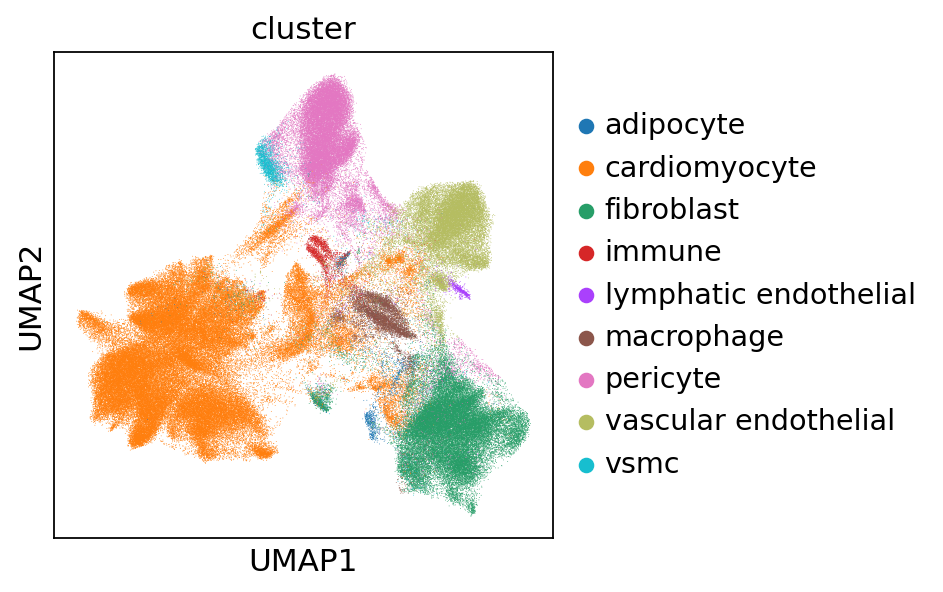

In [6]:
sc.pl.umap(adata, color='cluster')

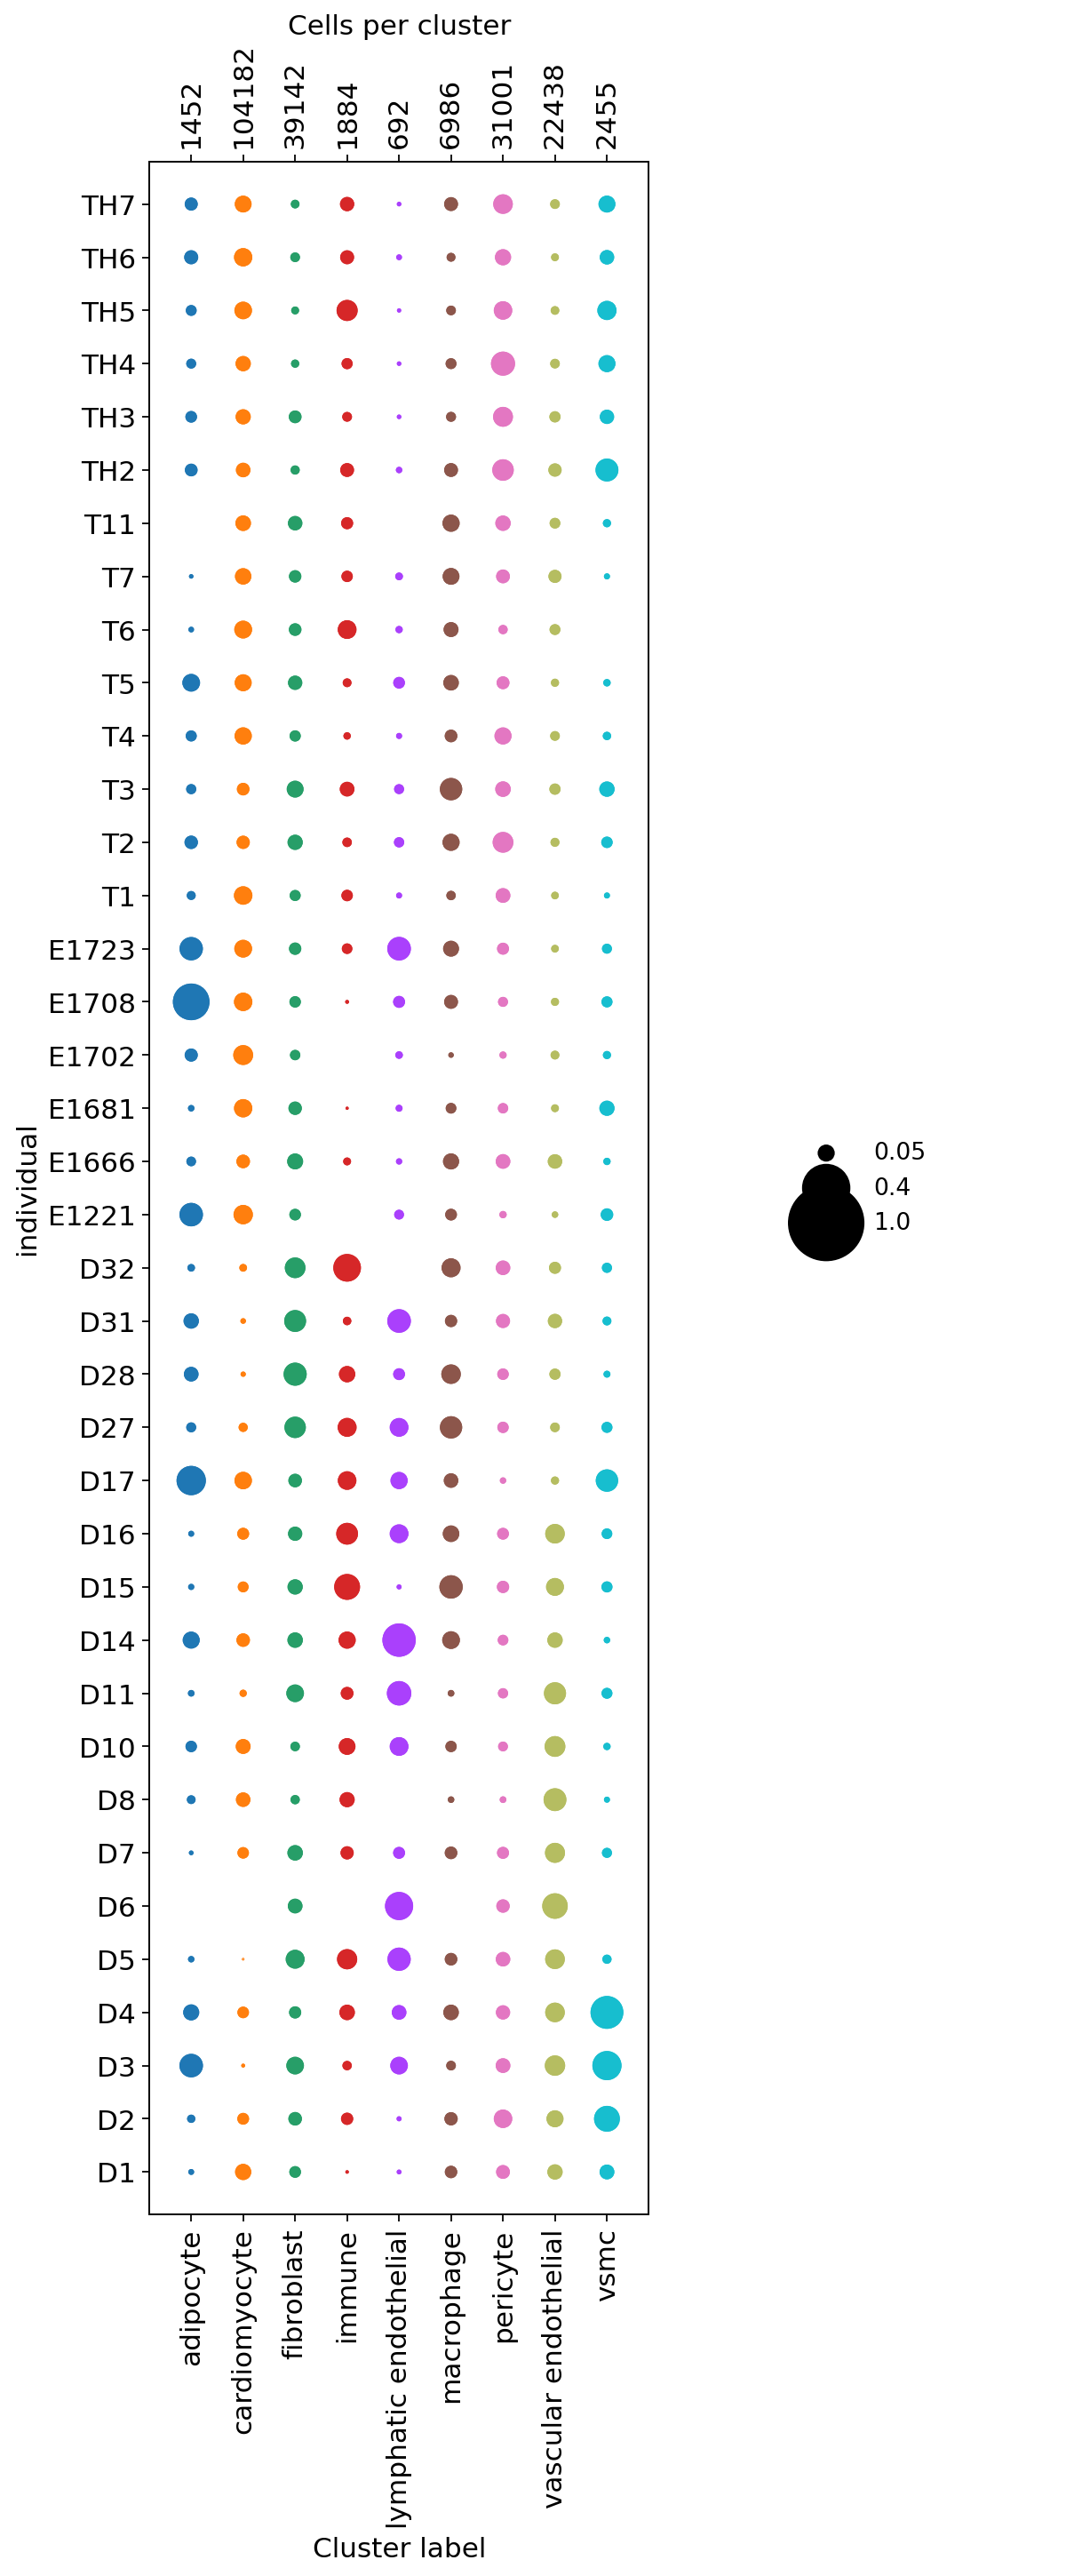

In [7]:
cell_count_dotplot(adata, key='individual', cluster_key='cluster', normalize='row_then_column',
                   size_factor=3, xrotation=90)

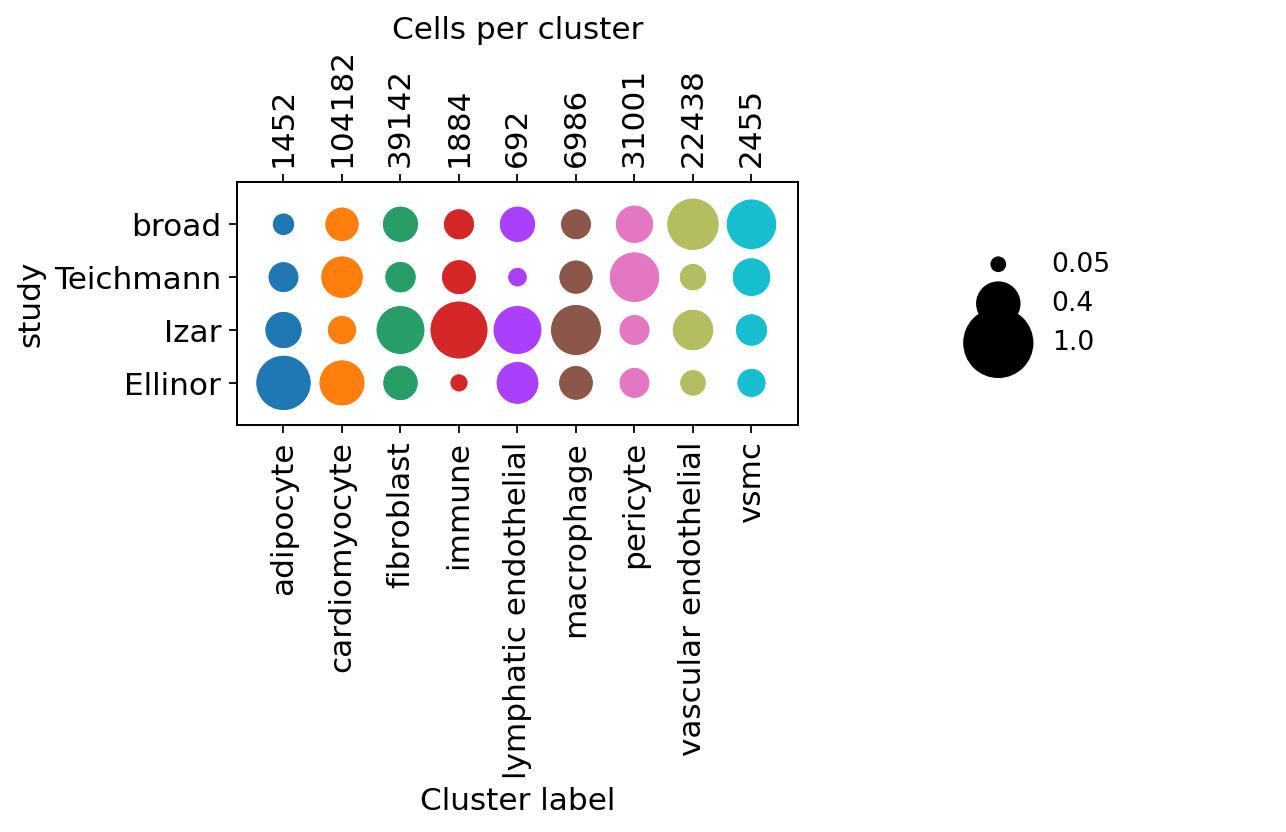

In [8]:
cell_count_dotplot(adata, key='study', cluster_key='cluster', normalize='row_then_column',
                   size_factor=2, xrotation=90)

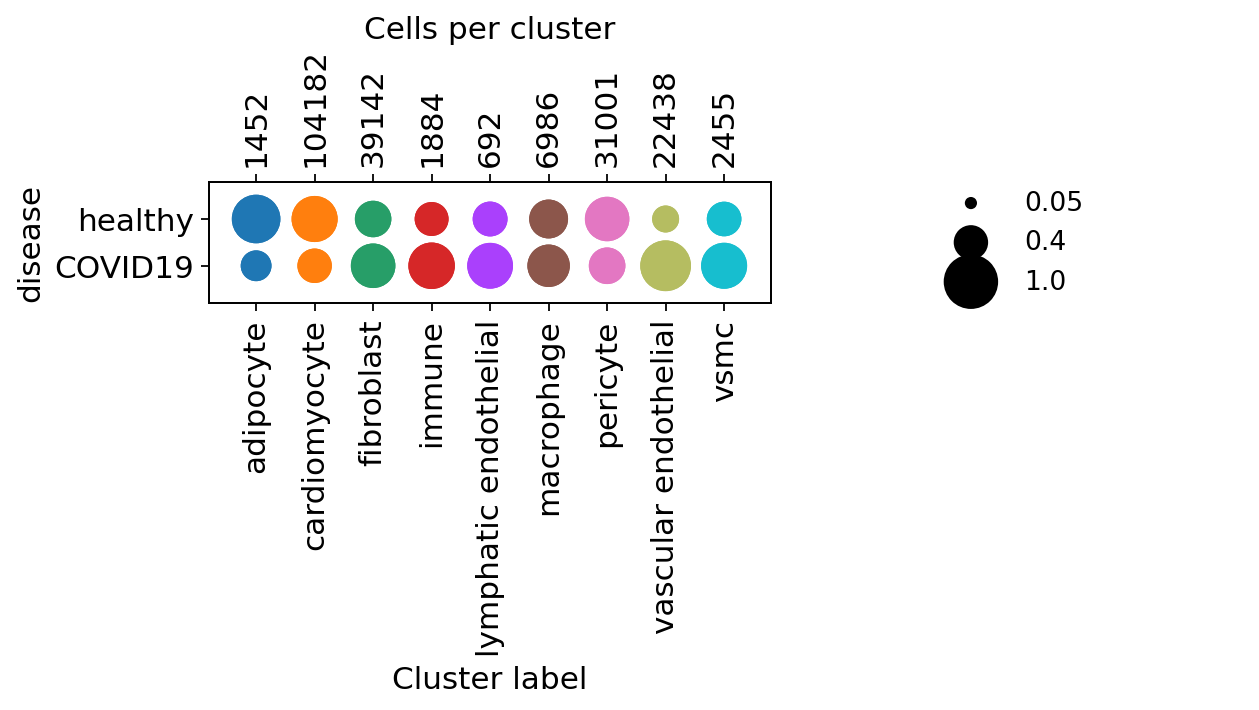

In [9]:
cell_count_dotplot(adata, key='disease', cluster_key='cluster', normalize='row_then_column',
                   size_factor=1.2, xrotation=90)

## Aggressively cleaned-up dataset

In [15]:
adata_clean = sc.read_h5ad('/home/jupyter-user/analysis/meta/heart_combined_for_de_SJF_extraQC.h5ad')

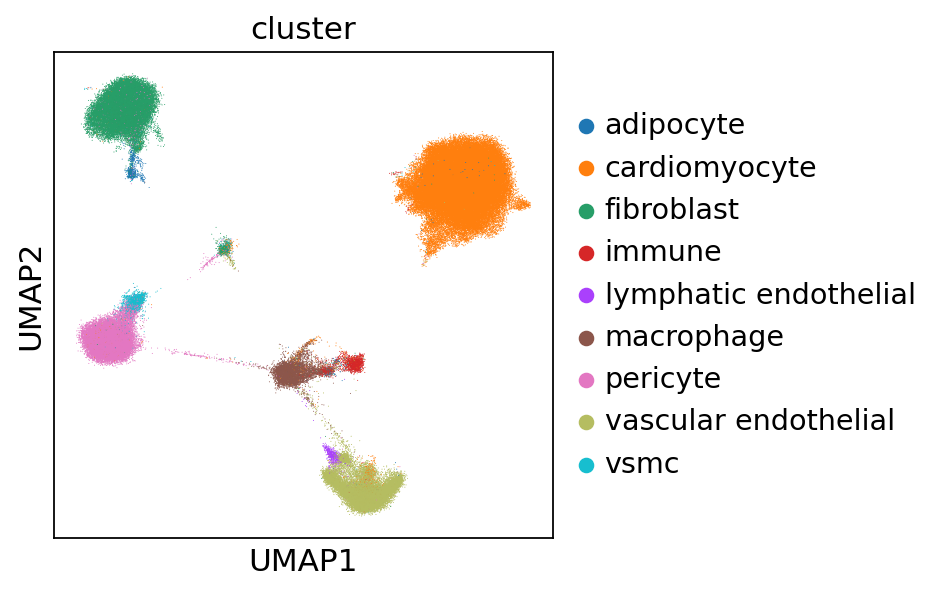

In [16]:
sc.pl.umap(adata_clean, color='cluster')

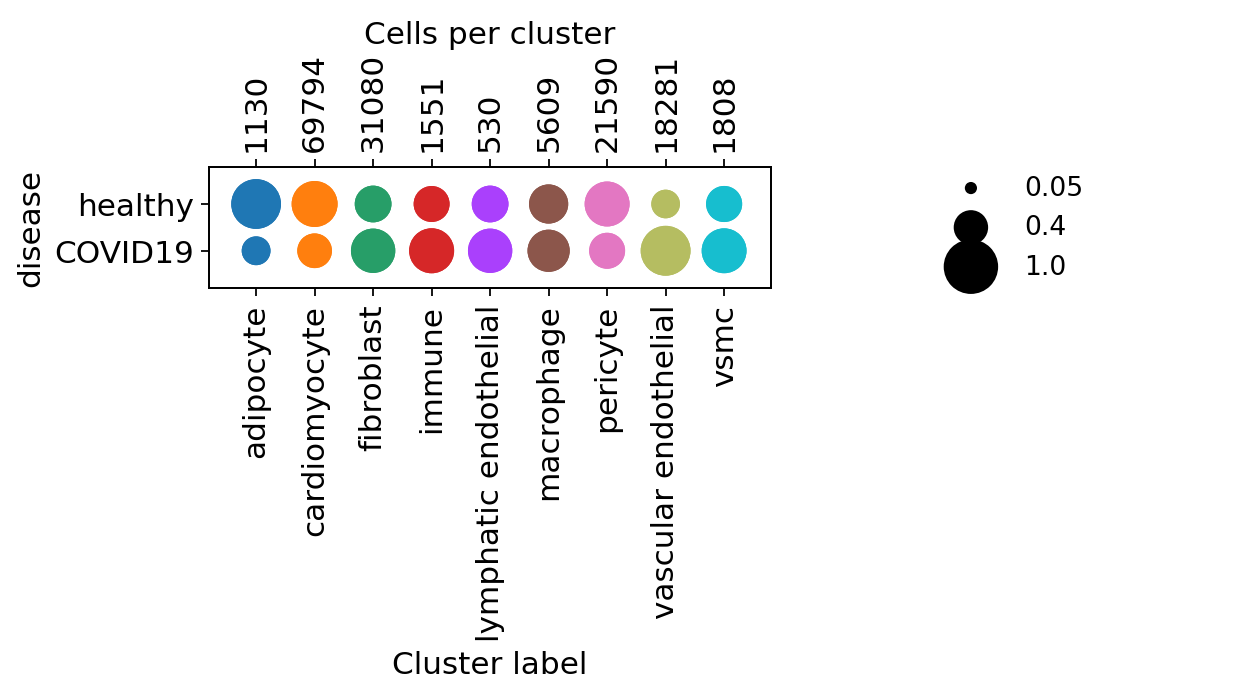

In [17]:
cell_count_dotplot(adata_clean, key='disease', cluster_key='cluster', normalize='row_then_column',
                   size_factor=1.2, xrotation=90)

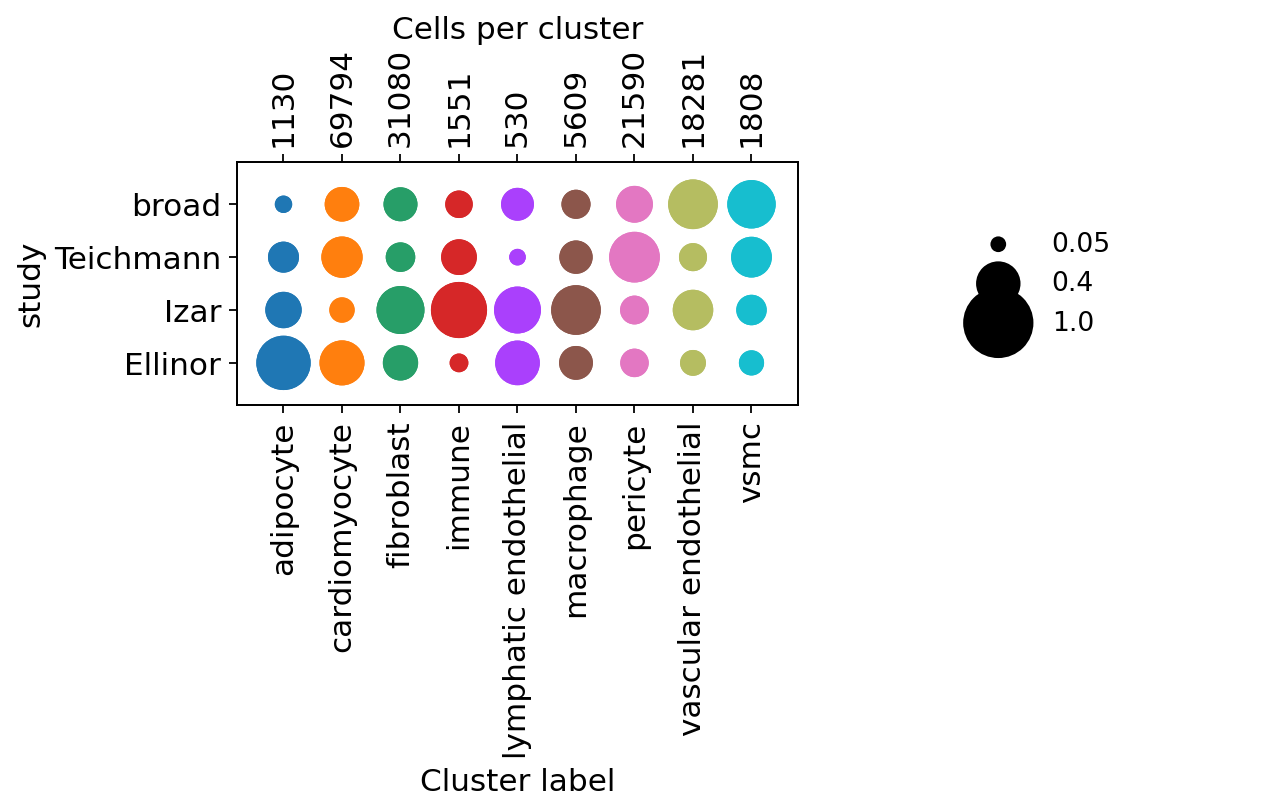

In [18]:
cell_count_dotplot(adata_clean, key='study', cluster_key='cluster', normalize='row_then_column',
                   size_factor=2, xrotation=90)

## More detail: scCODA

The two different versions, "clean" versus "all cells", really look very very similar from the point of view of the cell count dotplots.

Will use the full data here.

In [6]:
# from Mark Chaffin (Broad Institute)

import numpy as np

# Function to select the reference group
# From: https://arxiv.org/pdf/1904.08937.pdf
def ref_group_sd(adata):
    '''
    adata = the anndata object generated as input for scCODA
            adata.X has the counts for each cell type (row) 
            for each sample (column).
            adata.var has the cell types
            adata.obs has the samples
    '''
    tocat = []
    # for each cell type in your adata object
    for j in adata.var.index:
        SD = []
        # for each cell type that is not your target cell type
        for k in [x for x in adata.var.index if x!=j]:
            # Take the sample standard deviation of this log10(ratio of j/k) across samples
            SD_jk = np.std(np.array(np.log10(((adata[:,adata.var.index == j].X) + 1)/
                                             ((adata[:,adata.var.index == k].X) + 1))), ddof=1)
            SD.append(SD_jk)
        # take the median of these SDs across every pair of cell types (j, k)
        S_j = np.median(SD)
        out = pd.DataFrame([j, S_j]).transpose()
        out.columns = ['celltype', 'S_j']
        tocat.append(out)
    S_all = pd.concat(tocat)
    return(S_all)

In [7]:
adata.obs['cluster'].cat.reorder_categories(adata.obs['cluster'].value_counts().index.tolist(), inplace=True)

In [8]:
# get rid of low-cell samples

adata.obs['sample'].value_counts()

H0020_LV               13138
H0025_LV               12302
H0015_LV               10356
02-P005175-S041-R01    10257
LV_1723_2               9096
LV_1681_2               8853
LV_1723_1               8524
H0037_LV                8492
H0026_LV_V3             8196
H0035_LV                8107
LV_1681_1               7548
LV_1708_2               7112
LV_1666_2               7040
LV_1666_1               6411
HCAHeart7835148         5971
02-P118946-S043-R01     5832
HCAHeart7829978         4951
HCAHeart7702873         4596
HCAHeart7664652         4516
HCAHeart7664653         4357
HCAHeart7664654         4203
HCAHeart7888922         4073
HCAHeart7985086         3933
HCAHeart7698015         3913
02-P348762-S011-R01     3538
LV_1221_1               3515
02-P240970-S048-R01     3347
12-P617758-S012-R01     2957
LV_1708_1               2878
04-P079042-S071-R01     2384
LV_1702_1               2323
13-P999993-S001-R01     2006
LV_1702_2               1982
HCAHeart7880860         1922
04-P006354-S03

In [9]:
adata_goodsamples = adata[adata.obs['sample'].isin(adata.obs['sample'].value_counts()
                                                   [adata.obs['sample'].value_counts() > 500].index)]

In [10]:
adata_goodsamples.obs['sample'].value_counts()

H0020_LV               13138
H0025_LV               12302
H0015_LV               10356
02-P005175-S041-R01    10257
LV_1723_2               9096
LV_1681_2               8853
LV_1723_1               8524
H0037_LV                8492
H0026_LV_V3             8196
H0035_LV                8107
LV_1681_1               7548
LV_1708_2               7112
LV_1666_2               7040
LV_1666_1               6411
HCAHeart7835148         5971
02-P118946-S043-R01     5832
HCAHeart7829978         4951
HCAHeart7702873         4596
HCAHeart7664652         4516
HCAHeart7664653         4357
HCAHeart7664654         4203
HCAHeart7888922         4073
HCAHeart7985086         3933
HCAHeart7698015         3913
02-P348762-S011-R01     3538
LV_1221_1               3515
02-P240970-S048-R01     3347
12-P617758-S012-R01     2957
LV_1708_1               2878
04-P079042-S071-R01     2384
LV_1702_1               2323
13-P999993-S001-R01     2006
LV_1702_2               1982
HCAHeart7880860         1922
04-P006354-S03

In [11]:
pd.crosstab(adata_goodsamples.obs['sample'], adata_goodsamples.obs['cluster'])

cluster,cardiomyocyte,fibroblast,pericyte,vascular endothelial,macrophage,vsmc,immune,adipocyte,lymphatic endothelial
sample,,,,,,,,,
02-P005175-S041-R01,5198,1526,1134,2002,261,125,2,6,3
02-P118946-S043-R01,1405,1237,1255,1454,173,246,51,9,2
02-P240970-S048-R01,772,551,398,1149,143,237,51,26,20
02-P248880-S011-R01,1,589,162,450,34,5,36,1,22
02-P348762-S011-R01,802,1020,281,1274,93,17,37,1,13
04-P006354-S031-R01,657,141,29,806,8,2,24,3,0
04-P054921-S072-R01,597,129,69,558,29,3,26,5,15
04-P079042-S071-R01,164,926,128,1070,12,14,23,2,45
12-P485759-S012-R01,225,194,40,134,39,1,13,6,25


In [12]:
cell_matrix = pd.crosstab(adata_goodsamples.obs['sample'], adata_goodsamples.obs['cluster']).to_numpy()

In [13]:
cell_matrix.shape

(43, 9)

In [14]:
cell_df = pd.crosstab(adata_goodsamples.obs['sample'], adata_goodsamples.obs['cluster'])
cell_df.index.tolist()

['02-P005175-S041-R01',
 '02-P118946-S043-R01',
 '02-P240970-S048-R01',
 '02-P248880-S011-R01',
 '02-P348762-S011-R01',
 '04-P006354-S031-R01',
 '04-P054921-S072-R01',
 '04-P079042-S071-R01',
 '12-P485759-S012-R01',
 '12-P617758-S012-R01',
 '12-P852049-S011-R01',
 '12-P890292-S009-R01',
 '13-P999993-S001-R01',
 '13-P999994-S002-R01',
 '13-P999999-S001-R01',
 'H0015_LV',
 'H0020_LV',
 'H0025_LV',
 'H0026_LV_V3',
 'H0035_LV',
 'H0037_LV',
 'HCAHeart7664652',
 'HCAHeart7664653',
 'HCAHeart7664654',
 'HCAHeart7698015',
 'HCAHeart7702873',
 'HCAHeart7757636',
 'HCAHeart7829978',
 'HCAHeart7835148',
 'HCAHeart7880860',
 'HCAHeart7888922',
 'HCAHeart7985086',
 'LV_1221_1',
 'LV_1666_1',
 'LV_1666_2',
 'LV_1681_1',
 'LV_1681_2',
 'LV_1702_1',
 'LV_1702_2',
 'LV_1708_1',
 'LV_1708_2',
 'LV_1723_1',
 'LV_1723_2']

In [15]:
cell_df.columns.tolist()

['cardiomyocyte',
 'fibroblast',
 'pericyte',
 'vascular endothelial',
 'macrophage',
 'vsmc',
 'immune',
 'adipocyte',
 'lymphatic endothelial']

In [16]:
['COVID19' if (s.startswith('0') or s.startswith('1')) else 'healthy' for s in cell_df.index.tolist()]

['COVID19',
 'COVID19',
 'COVID19',
 'COVID19',
 'COVID19',
 'COVID19',
 'COVID19',
 'COVID19',
 'COVID19',
 'COVID19',
 'COVID19',
 'COVID19',
 'COVID19',
 'COVID19',
 'COVID19',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy',
 'healthy']

In [17]:
import anndata

def get_study(s):
    if s.startswith('LV'):
        return 'ellinor'
    elif s.startswith('H'):
        return 'teichmann'
    elif s.startswith('13'):
        return 'izar'
    else:
        return 'broad'

adata_coda = anndata.AnnData(X=cell_matrix, 
                             obs=pd.DataFrame(index=cell_df.index.tolist(),
                                              data={'condition': 
                                                    ['COVID19' if (s.startswith('0') or s.startswith('1')) 
                                                     else 'healthy' 
                                                     for s in cell_df.index.tolist()],
                                                    'study':
                                                    [get_study(s) for s in cell_df.index.tolist()]}),
                             var=pd.DataFrame(index=cell_df.columns.tolist()))

In [18]:
adata_coda

AnnData object with n_obs × n_vars = 43 × 9
    obs: 'condition', 'study'

In [19]:
adata_coda.obs

,condition,study
02-P005175-S041-R01,COVID19,broad
02-P118946-S043-R01,COVID19,broad
02-P240970-S048-R01,COVID19,broad
02-P248880-S011-R01,COVID19,broad
02-P348762-S011-R01,COVID19,broad
04-P006354-S031-R01,COVID19,broad
04-P054921-S072-R01,COVID19,broad
04-P079042-S071-R01,COVID19,broad
12-P485759-S012-R01,COVID19,broad
12-P617758-S012-R01,COVID19,broad


In [20]:
adata_coda.var.head()

""
cardiomyocyte
fibroblast
pericyte
vascular endothelial
macrophage


In [21]:
ref_group_sd(adata_coda)

,celltype,S_j
0,cardiomyocyte,0.739526
0,fibroblast,0.55421
0,pericyte,0.59531
0,vascular endothelial,0.603576
0,macrophage,0.595363
0,vsmc,0.619377
0,immune,0.75371
0,adipocyte,0.65256
0,lymphatic endothelial,0.715544


In [22]:
# !pip install sccoda

In [ ]:
import sccoda

In [24]:
from sccoda.util import data_visualization as viz

import matplotlib.pyplot as plt
%matplotlib inline

## Extended Data Figure 11e

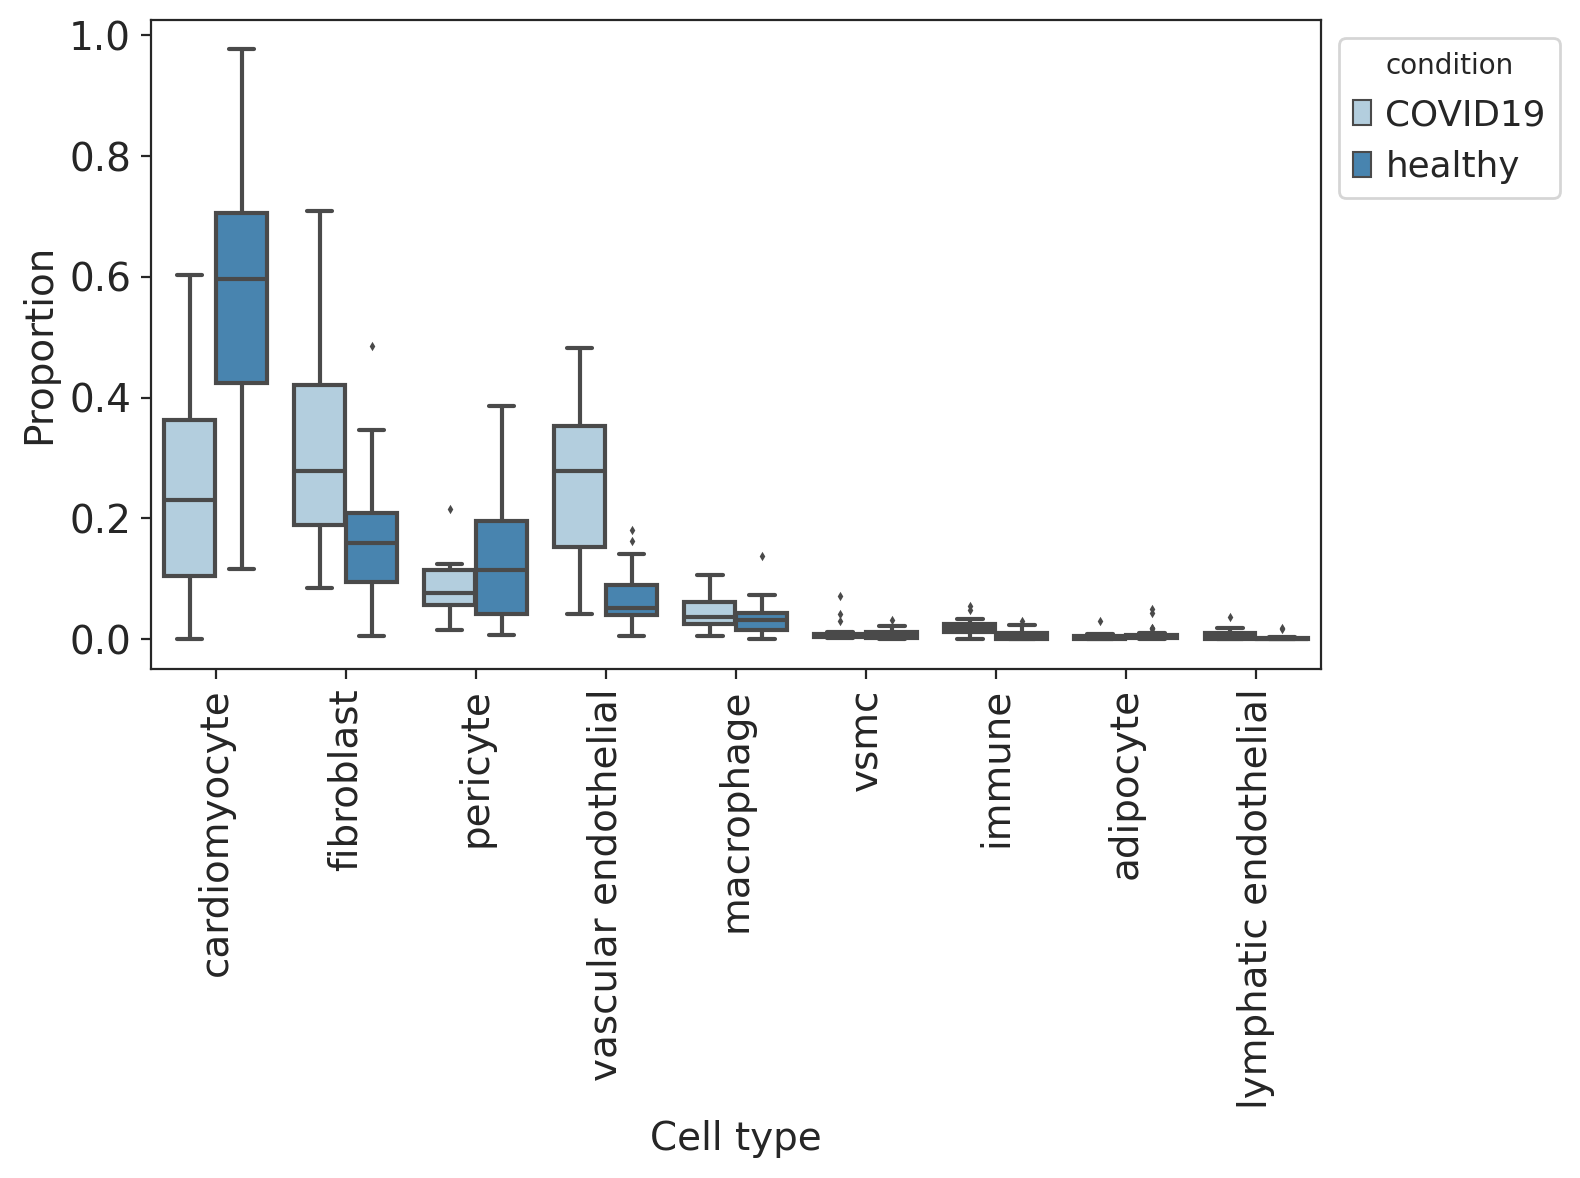

In [31]:
viz.boxplots(adata_coda, feature_name='condition', figsize=(8, 6))

plt.gcf().savefig('/home/jupyter-user/analysis/meta/heart_DE_cell_proportions.pdf',
                  bbox_inches='tight')
plt.show()

In [31]:
from sccoda.util import comp_ana as mod

model_salm = mod.CompositionalAnalysis(adata_coda, 
                                       formula='condition + study', 
                                       reference_cell_type='fibroblast')

Zero counts encountered in data! Added a pseudocount of 0.5.


In [36]:
# Run MCMC
sim_results = model_salm.sample_hmc()

MCMC sampling finished. (135.219 sec)
Acceptance rate: 65.7%


/home/jupyter-user/.local/lib/python3.7/site-packages/sccoda/util/result_classes.py:216: RuntimeWarning: Mean of empty slice.
  beta_nonzero_mean.append(beta_i_raw[beta_i_raw_nonzero].mean())
/home/jupyter-user/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [37]:
sim_results.summary()

Compositional Analysis summary:

Data: 43 samples, 9 cell types
Reference index: 1
Formula: condition + study

Intercepts:
                       Final Parameter  Expected Sample
Cell Type                                              
cardiomyocyte                    1.198      1048.400160
fibroblast                       1.357      1229.079291
pericyte                         0.403       473.437839
vascular endothelial             1.432      1324.805088
macrophage                      -0.101       286.008241
vsmc                            -0.831       137.829942
immune                          -0.636       167.506243
adipocyte                       -1.111       104.169630
lymphatic endothelial           -1.137       101.496125


Effects:
                                            Final Parameter  Expected Sample  \
Covariate            Cell Type                                                 
condition[T.healthy] cardiomyocyte                 1.180482      2560.753192   
          

In [38]:
print(sim_results.credible_effects())

Covariate             Cell Type            
condition[T.healthy]  cardiomyocyte             True
                      fibroblast               False
                      pericyte                 False
                      vascular endothelial      True
                      macrophage               False
                      vsmc                     False
                      immune                   False
                      adipocyte                False
                      lymphatic endothelial    False
study[T.ellinor]      cardiomyocyte             True
                      fibroblast               False
                      pericyte                 False
                      vascular endothelial     False
                      macrophage               False
                      vsmc                     False
                      immune                    True
                      adipocyte                False
                      lymphatic endothelial    False
st

In [39]:
sim_results.summary_extended(hdi_prob=0.9)

Compositional Analysis summary (extended):

Data: 43 samples, 9 cell types
Reference index: 1
Formula: condition + study
Spike-and-slab threshold: 0.593

MCMC Sampling: Sampled 20000 chain states (5000 burnin samples) in 135.219 sec. Acceptance rate: 65.7%

Intercepts:
                       Final Parameter  HDI 5%  HDI 95%     SD  \
Cell Type                                                        
cardiomyocyte                    1.198   0.886    1.526  0.196   
fibroblast                       1.357   1.169    1.542  0.114   
pericyte                         0.403   0.090    0.696  0.184   
vascular endothelial             1.432   1.101    1.739  0.199   
macrophage                      -0.101  -0.398    0.172  0.176   
vsmc                            -0.831  -1.156   -0.529  0.194   
immune                          -0.636  -1.022   -0.256  0.232   
adipocyte                       -1.111  -1.464   -0.756  0.221   
lymphatic endothelial           -1.137  -1.498   -0.790  0.216   

   

/home/jupyter-user/.local/lib/python3.7/site-packages/sccoda/util/result_classes.py:216: RuntimeWarning: Mean of empty slice.
  beta_nonzero_mean.append(beta_i_raw[beta_i_raw_nonzero].mean())
/home/jupyter-user/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [40]:
model_salm2 = mod.CompositionalAnalysis(adata_coda, 
                                       formula='condition', 
                                       reference_cell_type='fibroblast')

Zero counts encountered in data! Added a pseudocount of 0.5.


In [41]:
# Run MCMC
sim_results2 = model_salm2.sample_hmc()

MCMC sampling finished. (129.881 sec)
Acceptance rate: 66.1%


/home/jupyter-user/.local/lib/python3.7/site-packages/sccoda/util/result_classes.py:216: RuntimeWarning: Mean of empty slice.
  beta_nonzero_mean.append(beta_i_raw[beta_i_raw_nonzero].mean())
/home/jupyter-user/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [42]:
sim_results2.summary()

Compositional Analysis summary:

Data: 43 samples, 9 cell types
Reference index: 1
Formula: condition

Intercepts:
                       Final Parameter  Expected Sample
Cell Type                                              
cardiomyocyte                    0.820       926.055294
fibroblast                       1.218      1378.751895
pericyte                         0.246       521.617179
vascular endothelial             1.004      1113.133116
macrophage                      -0.191       336.949796
vsmc                            -0.900       165.825154
immune                          -0.835       176.961810
adipocyte                       -1.115       133.744859
lymphatic endothelial           -1.226       119.693456


Effects:
                                            Final Parameter  Expected Sample  \
Covariate            Cell Type                                                 
condition[T.healthy] cardiomyocyte                 1.574352      2600.357597   
                  

In [43]:
print(sim_results2.credible_effects())

Covariate             Cell Type            
condition[T.healthy]  cardiomyocyte             True
                      fibroblast               False
                      pericyte                  True
                      vascular endothelial      True
                      macrophage               False
                      vsmc                     False
                      immune                   False
                      adipocyte                False
                      lymphatic endothelial    False
Name: Inclusion probability, dtype: bool


In [44]:
sim_results2.summary_extended(hdi_prob=0.9)

Compositional Analysis summary (extended):

Data: 43 samples, 9 cell types
Reference index: 1
Formula: condition
Spike-and-slab threshold: 0.593

MCMC Sampling: Sampled 20000 chain states (5000 burnin samples) in 129.881 sec. Acceptance rate: 66.1%

Intercepts:
                       Final Parameter  HDI 5%  HDI 95%     SD  \
Cell Type                                                        
cardiomyocyte                    0.820   0.515    1.137  0.188   
fibroblast                       1.218   1.028    1.397  0.112   
pericyte                         0.246  -0.091    0.706  0.242   
vascular endothelial             1.004   0.614    1.363  0.228   
macrophage                      -0.191  -0.454    0.087  0.170   
vsmc                            -0.900  -1.159   -0.600  0.178   
immune                          -0.835  -1.177   -0.460  0.215   
adipocyte                       -1.115  -1.425   -0.792  0.201   
lymphatic endothelial           -1.226  -1.540   -0.965  0.182   

           

/home/jupyter-user/.local/lib/python3.7/site-packages/sccoda/util/result_classes.py:216: RuntimeWarning: Mean of empty slice.
  beta_nonzero_mean.append(beta_i_raw[beta_i_raw_nonzero].mean())
/home/jupyter-user/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
